In [1]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

In [2]:
BUF_SIZE=500
BATCH_SIZE=20

#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)

Cache file /home/aistudio/.cache/paddle/dataset/uci_housing/housing.data not found, downloading http://paddlemodels.bj.bcebos.com/uci_housing/housing.data 
Begin to download
............
Download finished


In [3]:
#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


In [7]:
# 切换到静态图模式
paddle.enable_static()

# 定义数据输入
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
y = fluid.layers.data(name='y', shape=[1], dtype='float32')

# 定义线性回归模型
y_predict = fluid.layers.fc(input=x, size=1, act=None)

In [8]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

In [9]:
# 定义优化器
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

In [10]:
test_program = fluid.default_main_program().clone(for_test=True)

In [11]:
# 选择使用CPU或GPU
use_cuda = False  # use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)  # 创建一个Executor实例exe
exe.run(fluid.default_startup_program())  # 初始化参数

[]

In [12]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])

In [13]:
# 定义迭代相关变量
iter = 0
iters = []
train_costs = []

# 绘制训练过程
def draw_train_process(iters, train_costs):
    title = "Training Cost"
    plt.title(title, fontsize=24)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Cost", fontsize=14)
    plt.plot(iters, train_costs, color='red', label='Training Cost') 
    plt.grid()
    plt.show()

Pass:0, Cost:747.75293
Test:0, Cost:212.10931
Pass:1, Cost:746.50897
Test:1, Cost:234.59810
Pass:2, Cost:636.53113
Test:2, Cost:335.39697
Pass:3, Cost:493.21918
Test:3, Cost:248.06247
Pass:4, Cost:584.84882
Test:4, Cost:252.69028
Pass:5, Cost:416.74228
Test:5, Cost:199.66733
Pass:6, Cost:521.30157
Test:6, Cost:14.15304
Pass:7, Cost:390.23972
Test:7, Cost:124.15826
Pass:8, Cost:314.10260
Test:8, Cost:169.25644
Pass:9, Cost:232.31192
Test:9, Cost:247.29150
Pass:10, Cost:237.04155
Test:10, Cost:116.64609
Pass:11, Cost:329.45276
Test:11, Cost:34.40044
Pass:12, Cost:157.39798
Test:12, Cost:90.77669
Pass:13, Cost:191.43965
Test:13, Cost:81.90437
Pass:14, Cost:281.33859
Test:14, Cost:23.00516
Pass:15, Cost:296.80591
Test:15, Cost:110.43793
Pass:16, Cost:243.87383
Test:16, Cost:46.44643
Pass:17, Cost:200.49084
Test:17, Cost:40.25392
Pass:18, Cost:203.83830
Test:18, Cost:75.55753
Pass:19, Cost:172.94516
Test:19, Cost:15.01968
Pass:20, Cost:301.04221
Test:20, Cost:75.39334
Pass:21, Cost:188.9025

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


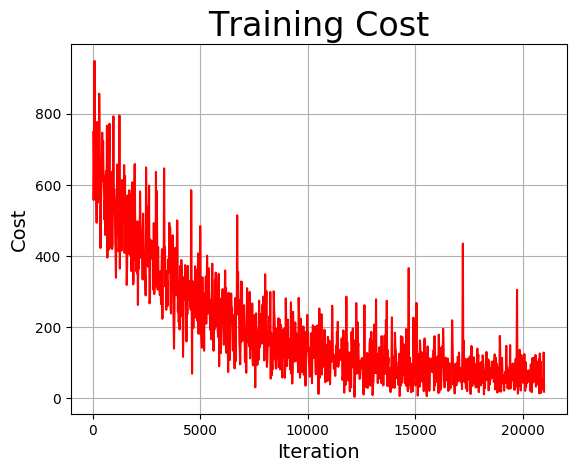

In [14]:
# 设置训练轮数
EPOCH_NUM = 50  # 需要根据需要设置轮数
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

# 开始训练
for pass_id in range(EPOCH_NUM):  # 训练EPOCH_NUM轮
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):
        train_cost = exe.run(program=fluid.default_main_program(),  # 运行主程序
                             feed=feeder.feed(data),              # 喂入一个batch的训练数据
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))  # 打印损失值
        iter = iter + BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])

    # 开始测试
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):
        test_cost = exe.run(program=test_program,
                            feed=feeder.feed(data),
                            fetch_list=[avg_cost])
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))

# 保存模型
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print('Saving models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir, ['x'], [y_predict], exe)

# 绘制训练过程
draw_train_process(iters, train_costs)

In [15]:
# 推测并绘制结果
infer_exe = fluid.Executor(place)  # 创建推测用的executor
inference_scope = fluid.core.Scope()

In [16]:
infer_results = []
ground_truths = []

# 绘制真实值和预测值对比图
def draw_infer_result(ground_truths, infer_results):
    title = 'Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1, 20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('Ground Truth', fontsize=14)
    plt.ylabel('Infer Result', fontsize=14)
    plt.scatter(ground_truths, infer_results, color='green', label='Infer Result')
    plt.grid()
    plt.show()

Infer Results: (House Price)
0: 13.20
1: 13.09
2: 13.00
3: 14.39
4: 13.80
5: 14.26
6: 13.42
7: 13.67
8: 11.82
9: 13.40
10: 11.06
11: 12.67
12: 13.29
13: 12.72
14: 12.29
15: 13.70
16: 14.33
17: 14.26
18: 14.65
19: 13.53
20: 14.09
21: 12.79
22: 14.55
23: 13.67
24: 13.83
25: 13.26
26: 14.34
27: 14.24
28: 15.04
29: 13.99
30: 13.70
31: 13.32
32: 13.32
33: 12.43
34: 12.29
35: 13.75
36: 13.76
37: 14.24
38: 14.36
39: 14.25
40: 13.25
41: 13.00
42: 14.18
43: 14.39
44: 14.36
45: 14.14
46: 13.65
47: 14.54
48: 14.63
49: 14.95
50: 13.53
51: 13.81
52: 13.36
53: 13.59
54: 14.53
55: 14.89
56: 14.54
57: 14.95
58: 15.07
59: 15.26
60: 15.68
61: 15.65
62: 13.85
63: 14.59
64: 15.26
65: 15.78
66: 15.44
67: 15.76
68: 15.86
69: 16.20
70: 14.52
71: 14.29
72: 15.04
73: 13.75
74: 14.76
75: 15.22
76: 16.44
77: 16.64
78: 16.80
79: 16.81
80: 16.34
81: 16.57
82: 15.58
83: 16.23
84: 15.68
85: 15.02
86: 14.44
87: 15.79
88: 16.44
89: 20.50
90: 20.73
91: 20.66
92: 19.41
93: 20.10
94: 20.35
95: 19.84
96: 19.98
97: 21.21
9

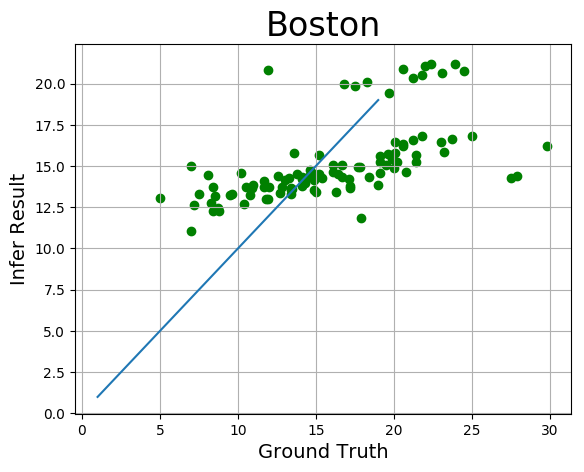

In [17]:
with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names, fetch_targets] = fluid.io.load_inference_model(model_save_dir, infer_exe)
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(), batch_size=200)
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y = np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,
                            feed={feed_target_names[0]: np.array(test_x)},
                            fetch_list=fetch_targets)

    print("Infer Results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("Ground Truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        ground_truths.append(val)
    draw_infer_result(ground_truths, infer_results)